# Getting Insights from Data - Starbucks Promotional Data 

### Introduction

The Starbucks data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). 


## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Questions
Three questions are posed from this dataset:
1. Do individuals spend more in store if they have a higher income?
2. Do older customers spend more than younger customers?
3. What is the difference in average spend between the three genders?

In [61]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [62]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Cleaning & Preprocessing

In [63]:
# View the portfolio table for any issues
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


The portfolio data is all visible above with no obvious issues to resolve.

In [64]:
# Determine how many records there are in the profile data
profile.shape

(17000, 5)

In [65]:
# Visualising the data structure

profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


The profile dataset is larger and will require some more tools to clean

In [66]:
# check for missing values
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [67]:
# check for duplicates
profile.duplicated().sum()

0

No duplicates but 2175 missing income values. These will be dropped because income and gender are important factors for the questions, and missing values cannot be meaningfully imputed from the data provided. Also the dataset is very large, so dropping these values likely won't have a significant effec on the overall trends.

In [68]:
# drop nulls and check 
profile = profile.dropna()
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [69]:
# check the new number of records 
profile.shape

(14825, 5)

In [70]:
# check for any customers under 18
profile[profile['age']<18].agg('count')

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [71]:
# check for any customers over 90
profile[profile['age']>90].agg('count')

gender              219
age                 219
id                  219
became_member_on    219
income              219
dtype: int64

In [72]:
# get the frequency distribution of the people over 90 
profile[profile['age']>90].groupby(['age']).agg('count')

,gender,id,became_member_on,income
age,,,,
91,47,47,47,47
92,40,40,40,40
93,29,29,29,29
94,33,33,33,33
95,22,22,22,22
96,8,8,8,8
97,13,13,13,13
98,5,5,5,5
99,5,5,5,5


There are a lot of customers over 90 but given the dataset has 17000 customers, 219 of them being over 90 years old is not unrealistic. Nor is it unrealistic that 5 people could be 101 years old. This information will be retained for the model 

In [73]:
# get number of records in the transcript data table
transcript.shape

(306534, 4)

In [74]:
# extract the value column which has objects in each row
values_df = transcript['value']

In [75]:
# convert the json objects in each row to a PD series
values_df = values_df.apply(pd.Series)

In [76]:
# merge the new values series to the existing table and drop the original value column
transcript_clean = pd.concat([transcript.drop('value', axis=1),values_df],axis=1)

In [77]:
# check the result
transcript_clean

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN


In [78]:
# Extract the transactions from the cleaned transcripts table
transactions = transcript_clean[transcript_clean['event']=='transaction'].drop(['offer id','offer_id','reward'], axis=1)

In [79]:
# Count how many transactions each individual completed
transactions.groupby('person').agg('count')

,event,time,amount
person,,,
0009655768c64bdeb2e877511632db8f,8,8,8
00116118485d4dfda04fdbaba9a87b5c,3,3,3
0011e0d4e6b944f998e987f904e8c1e5,5,5,5
0020c2b971eb4e9188eac86d93036a77,8,8,8
0020ccbbb6d84e358d3414a3ff76cffd,12,12,12
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,11,11,11
fff7576017104bcc8677a8d63322b5e1,6,6,6
fff8957ea8b240a6b5e634b6ee8eafcf,5,5,5


In [80]:
# Create a new dataset grouped by each person and their total spend
amount = transactions.groupby('person').agg('sum')['amount']

In [81]:
# Sanity check the data, some values are very low and some very high
# The very large values are likely to affect statistics like the mean
# The median will also be considered for analysing the data
amount.sort_values(ascending=True)

person
11d87e606c2f4d649fe09a5e84d048c2       0.05
4828b93dd6dd44eb9ec8417f0564a9b9       0.05
fc3444ae44044a218e160522f7de8d8d       0.05
999338157fd54f639b089cef0038e06a       0.05
37ca07481c124d98ac1eaca5ee1f4146       0.10
                                     ...   
73afdeca19e349b98f09e928644610f8    1319.97
626df8678e2a4953b9098246418c9cfa    1321.42
ae6f43089b674728a50b8727252d3305    1327.74
f1d65ae63f174b8f80fa063adcaa63b7    1365.66
3c8d541112a74af99e88abbd0692f00e    1608.69
Name: amount, Length: 16578, dtype: float64

In [82]:
# converting to a dataframe from a series
amount = pd.DataFrame(amount)

In [83]:
# re-adding the person ID back into the dataset as a column
amount['person'] = amount.index.values

In [84]:
# Visualising the data table
amount

,amount,person
person,,
0009655768c64bdeb2e877511632db8f,127.60,0009655768c64bdeb2e877511632db8f
00116118485d4dfda04fdbaba9a87b5c,4.09,00116118485d4dfda04fdbaba9a87b5c
0011e0d4e6b944f998e987f904e8c1e5,79.46,0011e0d4e6b944f998e987f904e8c1e5
0020c2b971eb4e9188eac86d93036a77,196.86,0020c2b971eb4e9188eac86d93036a77
0020ccbbb6d84e358d3414a3ff76cffd,154.05,0020ccbbb6d84e358d3414a3ff76cffd
...,...,...
fff3ba4757bd42088c044ca26d73817a,580.98,fff3ba4757bd42088c044ca26d73817a
fff7576017104bcc8677a8d63322b5e1,29.94,fff7576017104bcc8677a8d63322b5e1
fff8957ea8b240a6b5e634b6ee8eafcf,12.15,fff8957ea8b240a6b5e634b6ee8eafcf


In [85]:
# remove the person ID as index
amount.reset_index(drop=True, inplace=True)

In [86]:
# merge the customer demographics with the amount data
# merge on the ID and drop redundant columns
merged = pd.merge(profile, amount, how='inner', left_on = 'id', right_on='person').drop(['id','person','became_member_on'],axis=1)

In [87]:
# Convert the amount column to float from object
merged['amount']=merged['amount'].astype('float64')

# Answering the Questions
## Question 1 - Do individuals spend more in store if they have a higher income?

In [88]:
# Create a median income dataset from the merged data
income_median= merged.sort_values(by='income',ascending=True)

# get the median data grouped by income
income_median = income_median.groupby('income').agg('median')

# bring the income back into the dataset as a column and drop the indices
income_median['income']= income_median.index.values
income_median.reset_index(drop=True,inplace=True)

In [89]:
# As above, for income mean

income_mean= merged.sort_values(by='income',ascending=True)
income_mean = income_mean.groupby('income').agg('mean')
income_mean['income']= income_mean.index.values
income_mean.reset_index(drop=True,inplace=True)

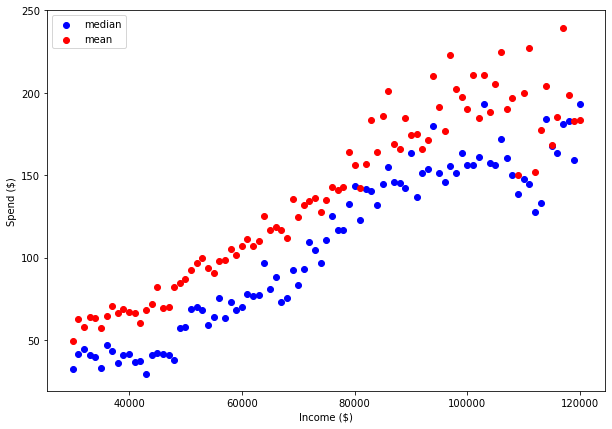

In [99]:
# Average Spend per groupings of customers who earn the same income
figure(figsize=(10,7))
plt.scatter(income_median['income'], income_median['amount'],c='b')
plt.scatter(income_mean['income'], income_mean['amount'],c='r')
plt.xlabel('Income ($)')
plt.ylabel('Spend ($)')
#plt.title('Customer Spend based on Income')
plt.legend(['median','mean'])

There is some difference between the median and the mean values for each income, and the mean appears to be consistently above the median spend, implying that for a given income, the customer spend appears to skew towards more average spend. 

Looking at the trends for both median and mean, as income increases there is a clear increase in the average spend too, up to a point at $100,000 income. At income higher than 100,000 there is greater variability in the average spend. 

In general, it can be concluded that customers who have a higher income are likely to spend more money in the stores. 

## Question 2 - Do older customers spend more than younger customers?

In [91]:
# Median calculated based on age grouping
age_median= merged.sort_values(by='age',ascending=True)
age_median = age_median.groupby('age').agg('median')
age_median['age']= age_median.index.values
age_median.reset_index(drop=True,inplace=True)

In [92]:
# Mean calculated based on age grouping
age_mean= merged.sort_values(by='age',ascending=True)
age_mean = age_mean.groupby('age').agg('mean')
age_mean['age']= age_mean.index.values
age_mean.reset_index(drop=True,inplace=True)

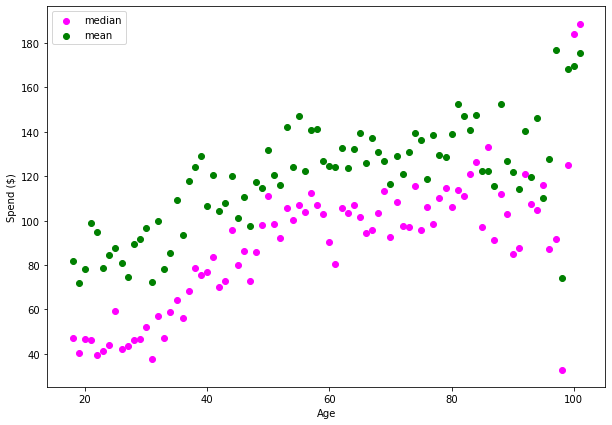

In [100]:
# Average spend for each age grouping
figure(figsize=(10,7))
plt.scatter(age_median['age'], age_median['amount'],c='magenta')
plt.scatter(merged_agem['age'], merged_agem['amount'],c='g')
plt.xlabel('Age')
plt.ylabel('Spend ($)')
#plt.title('Customer Spend based on Age')
plt.legend(['median','mean'])

There is again some difference between the mean and median spend per age. The mean is consistently larger, indicating that the spend per age group also skews to higher spend. As age increases though, there is a less conclusive result in the spend. It appears that customers who are aged 50 and over will spend a similar amount in stores, but for customers aged between 20 and 50 there appears to be a trend showing that as age increases, spend also increases. The relationship appears to break down at customers over 95, but this is to be expected considering the dataset has fewer than 15 people for each age after 95. These smaller groups are likely to significantly impact the mean and median statistics.

## Question 3 - What is the difference in average spend between the three genders (Female, Male and Other)?

In [94]:
# Pivot table for each gender (given it is categorical)
gender_stats = pd.pivot_table(merged, values='amount',columns='gender',aggfunc={np.mean,np.median,np.min,np.max,'count'})

In [95]:
# Renaming the indices and columns 
gender_stats.index = ['Max','Min','Count','Mean','Median']
gender_stats.columns=['Female','Male','Other']

In [101]:
# reordering the data
gender_stats.reindex(['Count','Mean','Median','Min','Max'])

,Female,Male,Other
Count,5993.000000,8295.000000,204.000000
Mean,144.117304,101.855438,129.198725
Median,119.070000,65.640000,97.500000
Min,0.410000,0.150000,1.370000
Max,1327.740000,1608.690000,857.750000


The count provides a total number of customers classified for each gender, in this dataset the Other gender is under-represented with only 204 people, and there are 2,302 more Male customers than Female. The statistics around the Male and Female customers can be used with greater confidence given the size of the dataset. The data indicates that Female customers on average spend 41% more than Male customers, while those who identify as Other spend 27% more than Male customers. The median statistics show a similar trend where the Male customers have the lowest spend again, followed by Other and then Female spending the most. Incidentally, the largest spend in the dataset across the 30-day period was $1,608 and this was spent by a Male customer. So despite the largest spend being from a Male customer, it appears that on average a Male customer will spend less than a Female customers.